In [1]:
#The following code is from the paper: 'Beyond Rotatable Bond Counts: Capturing 3D Conformational Flexibility in a Single Descriptor'
#I liked the code; Thankfully, the code is given, with a very little modification it works perfectly and the idea is simple but effective
#and I found it interesting
#link: https://pubs.acs.org/doi/pdf/10.1021/acs.jcim.6b00565

In [2]:
!pip install rdkit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 29.8 MB/s eta 0:00:00


In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import OrderedDict
import numpy as np

In [4]:
def GenerateConformers(mol, numConfs):
  molecule = Chem.AddHs(mol)
  conformerIntegers = []
  conformers = AllChem.EmbedMultipleConfs(molecule, numConfs, pruneRmsThresh = 0.5, numThreads =3)
  optimized_and_energies = AllChem.MMFFOptimizeMoleculeConfs(molecule, maxIters=600, numThreads=3, nonBondedThresh=100.0)
  EnergyDictionaryWithIDAsKey = {}
  FinalConformersToUse = {}
  for conformer in conformers:
    optimized, energy = optimized_and_energies[conformer]
    if optimized == 0:
      EnergyDictionaryWithIDAsKey[conformer] = energy
      conformerIntegers.append(conformer)

  lowestenergy = min(EnergyDictionaryWithIDAsKey.values())

  for k, v in EnergyDictionaryWithIDAsKey.items():
    if v == lowestenergy:
      lowestEnergyConformerID = k

  FinalConformersToUse[lowestEnergyConformerID] = lowestenergy
  molecule = AllChem.RemoveHs(molecule)
  matches = molecule.GetSubstructMatches(molecule, uniquify = False)
  maps = [list(enumerate(match)) for match in matches]

  for conformerID in EnergyDictionaryWithIDAsKey.keys():
    okayToAdd = True

    for finalconformerID in FinalConformersToUse.keys():
      RMS = AllChem.GetBestRMS(molecule, molecule, finalconformerID, conformerID, maps)
      if RMS < 1.0:
        okayToAdd = False
        break

    if okayToAdd:
      FinalConformersToUse[conformerID] = EnergyDictionaryWithIDAsKey[conformerID]
  sortedDictionary = OrderedDict(sorted(FinalConformersToUse.items(),
                                        key=lambda t: t[1]))
  #print(sortedDictionary)
  energies = [val for val in sortedDictionary.values()]

  return energies

def Calc_nConf20(energylist):
  energy_descriptor = 0
  relativeenergies = np.array(energylist) - energylist[0]

  for energy in relativeenergies[1:]:
    if 0<= energy <20:
      energy_descriptor += 1
  return energy_descriptor

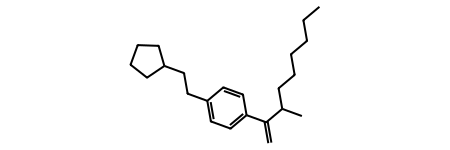

In [5]:
example_molecule = Chem.MolFromSmiles('C=C(C(C)CCCCCC)C1=CC=C(CCC2CCCC2)C=C1')
example_molecule

In [6]:
example_energylist = GenerateConformers(example_molecule, 50)
example_energy_descriptor = Calc_nConf20(example_energylist)
print(example_energy_descriptor)

28


In [ ]:
#the idea can be used in ML model building, I think it is an useful feature.